# Ensemble Learning

## Intro: wisdom of the crowd

Wisdom of the crowd: veel mensen kunnen samen een redelijke inschatting maken over een bepaalde vraag. Als we verschillende classifiers of regressors verzamelen en een soort *gemiddelde* nemen van hun uitspraken, komen we tot een stabieler, beter antwoord. Deze techniek heet in het algemeen *ensemble learning*, en in het geval van Decision trees spreken we ook wel van een *random forest*. Een bos is tenslotte een verzameling bomen.

Ensemble methoden kunnen bestaan uit verschillende onderling onsamenhangende (losse) classifiers. Het is niet ongewoon, en zelfs de bedoeling, dat de ensemble classifier een betere accuracy heeft dan de beste van haar componenten ! Met andere woorden: uit een aantal minder goede onderdelen kan soms een beter en robuuster onderdeel worden samengesteld. 

In [1]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Laat ons starten met een 'voting classifier' die bestaat uit 3 verschillende classifiers, die elk de moons-dataset proberen in te delen:

In [3]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

De individuele onderdelen van deze classifier hebben volgende accuracy scores:

In [4]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


Echter, de ensemble method is in het algemeen nog net iets slimmer:

In [5]:
voting_clf.score(X_test, y_test)

0.912

Als alle onderdelen van de ensemble methode ook 'class prediction' ondersteunen zoals uitgelegd bij een decision tree, dan kun je nog net iets beter inschatten door de aantallen van al die klasses bij elkaar op te tellen. Voters die zeker zijn van hun stuk (door goede aantallen) krijgen op die manier meer gewicht in het eindresultaat. 

Om het in onderstaand voorbeeld te laten werken moet je bij een SVC de probability parameter even expliciet op true zetten.

In [6]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

## Bagging en Pasting
1 manier om verschillende classifiers te hebben is om dezelfde soort te gebruiken, maar op een lichtjes afwijkende dataset. We nemen daarvoor telkens een random deel van de gehele dataset. Er worden dan willekeurige stalen genomen uit een dataset. Naargelang de exacte techniek, gebruiken we volgende terminologie:
- bij het willekeurig selecteren kunnen er dubbels optreden: *bagging* (van *bootstrap aggregating*)
- bij het willekeurig selecteren laten we geen dubbels toe: *pasting*

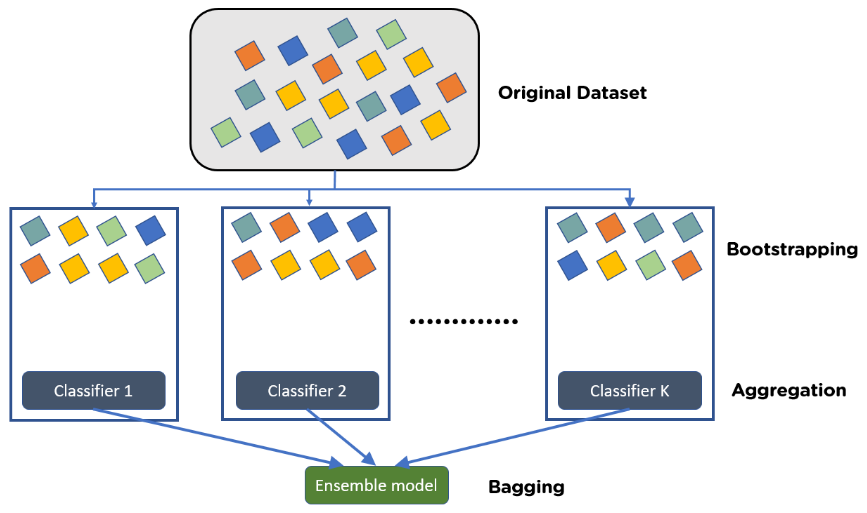

In [7]:
from IPython.display import Image
Image(filename='images/bagging.png')


Wanneer alle subcomponenten zijn getrained, kan er een gehele uitspraak worden gedaan:
- voor classificatie wordt er meestal gekozen voor een 'statistische keuze', typisch de meest voorkomende voorspelling (majority vote)
- voor regressie wordt er meestal gekozen voor het gemiddelde.

Door de [wet van de grote getallen](https://nl.wikipedia.org/wiki/Wetten_van_de_grote_aantallen), gaat zowel de bias als de variantie naar beneden. Herinner:
- Bias: foute veronderstellingen, zoals een dataset met duidelijke 'kromming' lineair proberen te fitten. Een model met hoge bias is waarschijnlijk een underfit
- Variance: sensitiviteit voor variatie in de data; een model dat veel vrijheidsgraden heeft en de trainingsdata (te) goed fit, is mogelijk een overfit model.
Naast die twee oorzaken van fouten, die we natuurlijk als modelmakers zo klein mogelijk proberen te krijgen, is er nog een derde niet te vergeten aspect:
- Ruis: in het Engels noise genoemd: deze fout, bvb door de beperking van een meettoestel, door de aard van het probleem (sommige dingen zijn nu éénmaal onderhevig aan kans en dus wat 'ruis'). Hier hebben we, buiten misschien het goed cleansen van de data, geen vat op.

Omdat de subcomponenten onafhankelijk van mekaar kunnen rekenen, kan dit process parallel worden uitgevoerd en is deze methode dus heel goed schaalbaar.

Implmentatie gebeurt als volgt:

In [9]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

Er worden 500 classifiers getrained, en elke Decision Tree classifier gebruikt 100 datapunten. De parameter n_jobs = -1 geeft aan dat we alle cores van de beschikbare machine willen gebruiken. je kan dit bijvoorbeeld hier beperken tot een vast aantal indien gewenst.

Opgelet: voor max_samples is de parameter overloaded: als je een integer waarde geeft, dan geef je expliciet aan hoeveel items er moeten worden geselecteerd. Als je een float tussen 0 en 1 geeft, dan duidt je aan welk proportioneel deel van de training date je wil gebruiken, bijvoorbeeld 0.5 voor de helft per estimator.

We vergelijken nu een enkele decision tree met onze 500 decision trees met bagging:

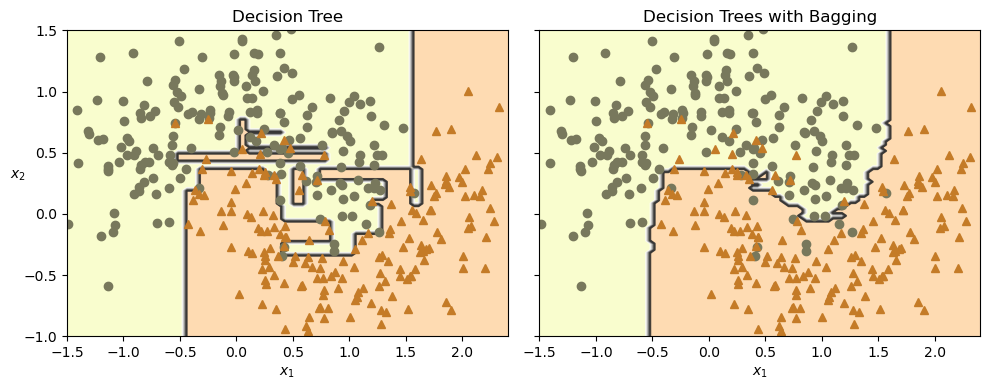

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

### Out-of-bag (oob) evaluatie

Het standaard gedrag van bagging selecteert per boom evenveel items als de training set, maar kiest deze met teruglegging. Hierdoor zullen bijna zeker niet alle items wordt geselecteerd, maar typisch slechts 63%. De items die niet worden gekozen, noemen we de *out-of-bag*-instances (oob). Daardoor kan een ensemble worden geëvalueerd zonder de nood aan een extra valuation set: als er veel estimators (onderdelen van het ensemble model) zijn, dan is elk item uit de training set een oob-item voor een aantal estimators. Op deze manier kun je als de dit doet voor de hele training set, de accuracy van het gehele ensemble model berekenen, dit noemen we de *out-of-bag-score* of oob-score.

In [10]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

je kunt ook voor een item de oob-decision functie aanroepen, eg de voorspelde klasse op basis van de predictors die deze data niet bevatten:

In [11]:
bag_clf.oob_decision_function_[:3]  # probas for the first 3 instances

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

In [13]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

### Random patches

Het is ook mogelijk om, naast de variatie in training samples per estimator, ook te variëren in welke features je meegeeft aan elke estimator. Dit noemen we *Random patches*. Wanneer we enkel de features variëren, maar de samples wel allemaal gebruiken bij elke estimator, spreken we van *random subspaces*.

## Random Forests

Naast de *BaggingClassifier* is er ook een specifieke *RandomForestClassifier*, die is net iets handiger om mee te werken als je met onderliggende Decision Trees werkt. Het random forest algoritme werkt een beetje anders: het laat namelijk elke decision tree voor elke stap niet de beste feature zoeken om te splitsen; maar beperkt zich tot een random selectie van features. Op die manier is er opnieuw meer variatie, wat weliswaar leidt tot meer bias, maar minder risico op overfitting, wat voor decision trees sowieso het grootste risico is. Dit kan je op zich ook afdwingen in een BaggingClassifier door de parameter max_features = 'sqrt' mee te geven, maar zoals gezegd is het ingebakken voor een RandomForrestClassifier.

In [27]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [28]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, n_jobs=-1, random_state=42)

Ze zijn effectief identiek:

In [29]:
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
np.all(y_pred_bag == y_pred_rf)  # zelfde predictions

True

### Feature importance
Om eventueel te bekijken in de labos

## Boosting

Het idee achter boosting is om in plaats van de onderliggende predictors van een ensemble method onafhankelijk van elkaar te trainen, deze sequentieel te trainen: het ene model neemt de output van de ene als input. Op die manier 'verbeteren' de methodes elkaar. Er zijn heel veel verschillende technieken, waarvan we er een tweetal zullen bekijken:
- AdaBoost
- Gradient Boosting


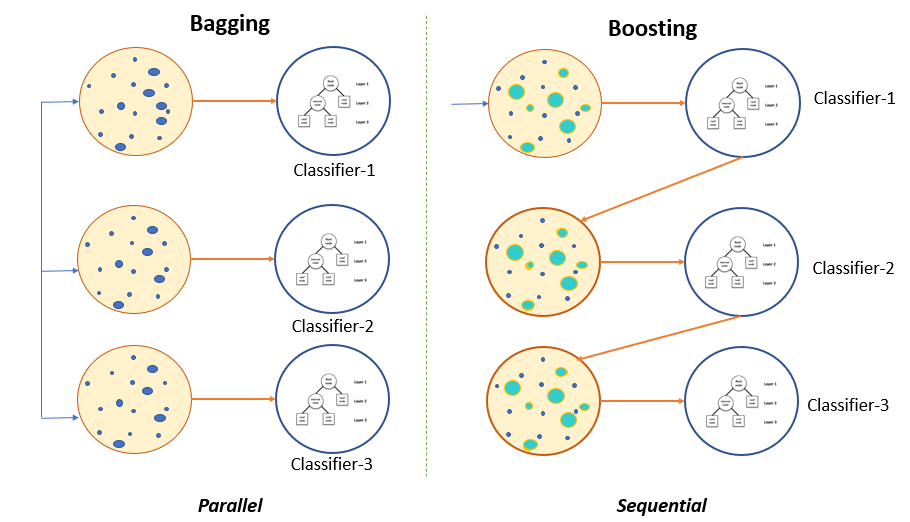

In [13]:
from IPython.display import Image
Image(filename='images/boosting.png')

### AdaBoost

Adaboost werkt door training items die specifiek slecht werden getrained door een classifier, meer gewicht te geven voor de volgende classifier, om deze dus te forceren hier meer aandacht aan te besteden. Er wordt dus na elke classifier al een evaluatie gemaakt en deze evaluatie is van belang voor de trainingsfase van de volgende classifier, etc. Het volgend voorbeeld toont de decision boundaries van 5 opeenvolgende predictors in de moons dataset. 

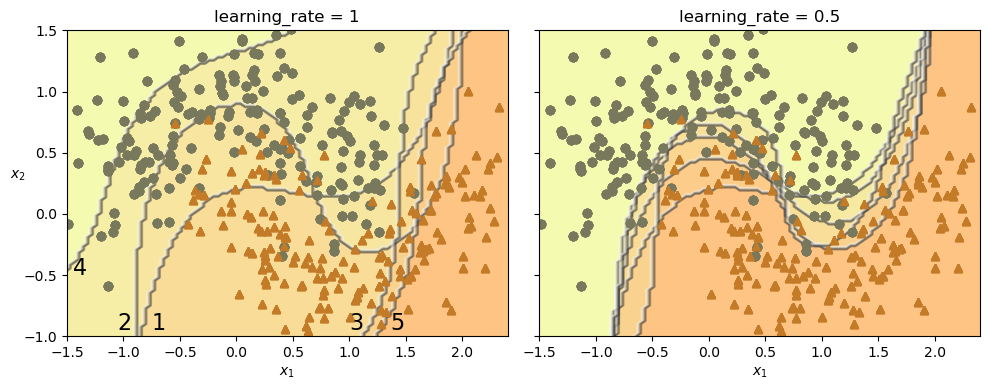

In [18]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation 7-3
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()


De exacte manier van hoe deze gewichten na evaluatie worden bepaald, zou ons hier te ver leiden, maar dit is hoe je adaBoost kan gebruiken in de praktijk:

In [14]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30,
    learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

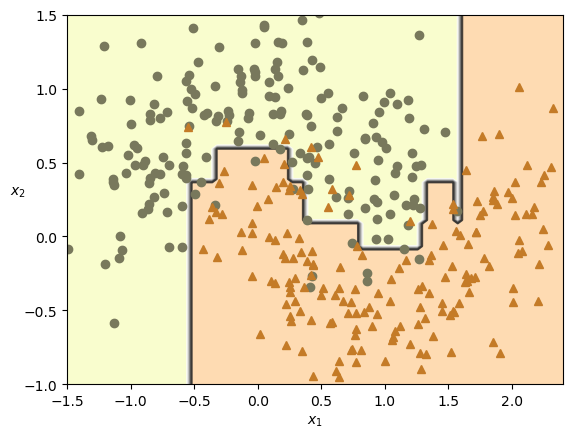

In [15]:
plot_decision_boundary(ada_clf, X_train, y_train)

### Gradient Boosting

Deze method gaat elke volgende predictor gebruiken om de *fouten* van de vorige predictor te voorspellen, en werkt vooral goed voor regressie. Op die manier is de totale voorspelling dan de som van de onderliggende predictors in de ensemble methode. We bekijken als voorbeeld volgende kwadratische dataset met nogal wat ruis:

In [16]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + Gaussian noise

Hierop fitten we eerst een simpel model:

In [17]:
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

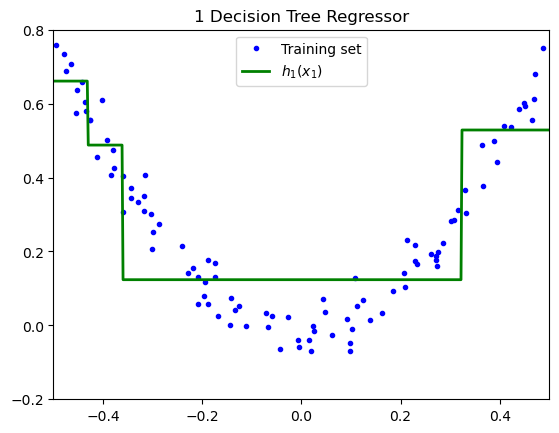

In [18]:
#plot maken
def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
plt.title("1 Decision Tree Regressor")
plt.show()

Nu kunnen we een regressie loslaten op de fout die deze regressor elke keer maakt. Vervolgens herhalen we het process een paar keer:

In [22]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

In [23]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

In [24]:
#een finale voorspelling maken: alles optellen
X_new = np.array([[-0.4], [0.], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

array([0.49484029, 0.04021166, 0.75026781])

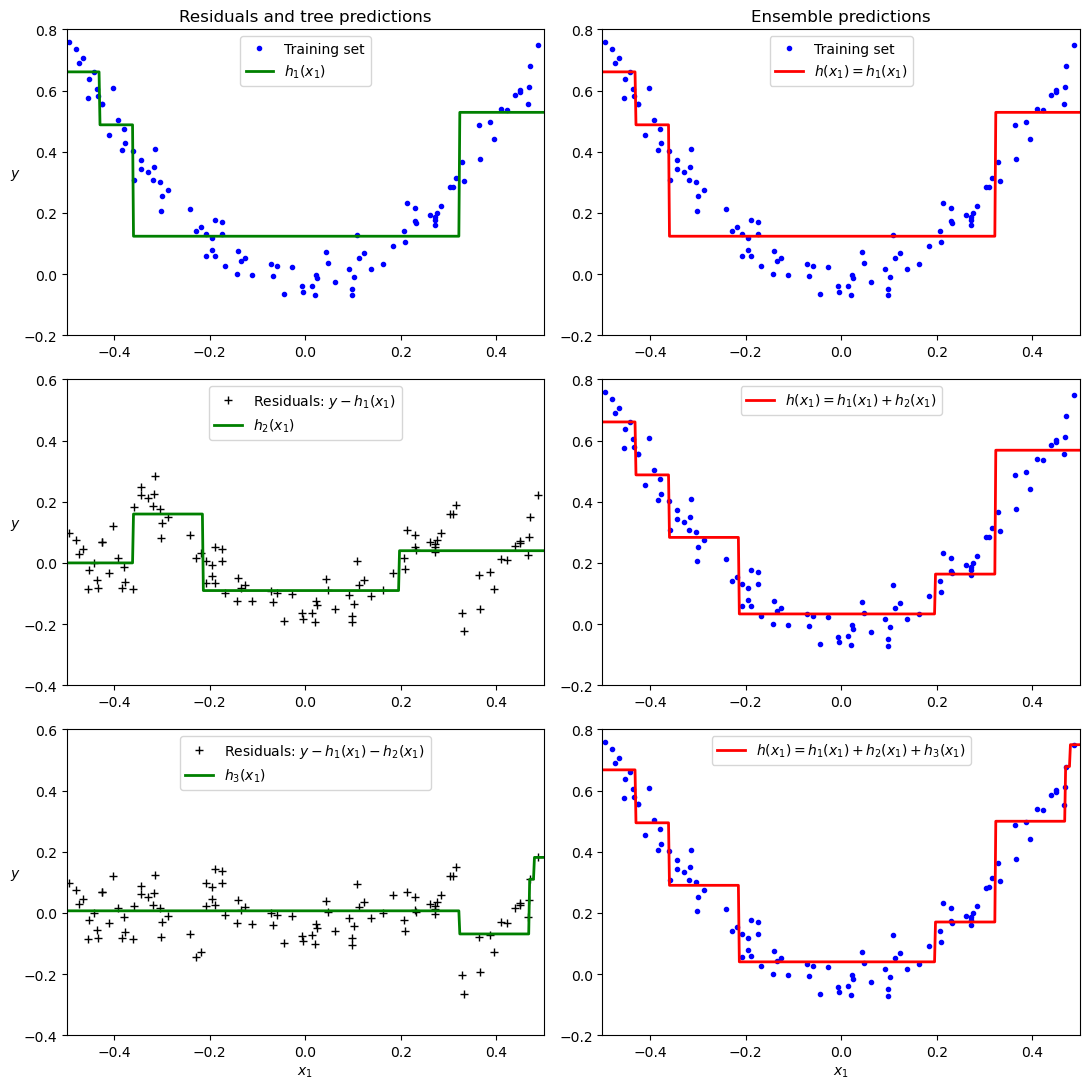

In [25]:
plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")

save_fig("gradient_boosting_plot")
plt.show()

Dit kan een stuk simpeler door 1 ingebakken methode te gebruiken. De learning rate bepaalt hoe hard elke boom meetelt: bij een lagere waarde gaat het process trager, maar is er minder kans op overfitting. Deze techniek, meer algemeen het kiezen van waardes waardoor er meer iteraties nodig zijn maar de algemene oplossing beter is, heet *shrinkage*.

In [26]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                                 learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

### XGBoost

XGBoost is een populaire boost libary. Ze is heel efficiënt en wordt in de praktijk vaak gebruikt als alternatief voor Gradient Boosting. Deze library moet je apart installeren ([documentatie](https://xgboost.readthedocs.io/en/stable/)).

In [22]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train,y_train)

y_pred = xgb_reg.predict(X_val)

Early stopping is ingebouwd bij XGBoost:

In [23]:
xgb_reg.fit(X_train,y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)

[0]	validation_0-rmse:0.20524
[1]	validation_0-rmse:0.14578
[2]	validation_0-rmse:0.10609
[3]	validation_0-rmse:0.08028
[4]	validation_0-rmse:0.06371
[5]	validation_0-rmse:0.05469
[6]	validation_0-rmse:0.05047
[7]	validation_0-rmse:0.04814
[8]	validation_0-rmse:0.04692
[9]	validation_0-rmse:0.04584
[10]	validation_0-rmse:0.04613
[11]	validation_0-rmse:0.04627


/home/bruno/miniconda3/envs/ml_algorithms/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### Wanneer boosting gebruiken ?

Boosting is aangeraden wanneer de onderdelen van het ensemble model, ook wel de *weak learners* genoemd, op zichzelf geen fantastisch resultaat leveren. Iteratieve modellen kan je gebruiken wanneer:
- bagging en pasting niet goed werken
- een complex probleem met hoge predictiekwaliteit is nodig
- bias en variantie moeten laag blijven, voor een goede veralgemening op nieuwe ongeziene data.


#### En welke boosting dan ?
- AdaBoost
    - vooral voor datasets met veel ruis en outliers
    - werkt goed met heel simpele weak learners
- Gradient Boosting:
    - Dit is de default keuze
    - Er zijn meer parameters, dus je kan meer finetunen dan AdaBoost. Maar daar heb je dan ook meer werk mee
- XGBoost
    - Te overwegen wanneer Gradient Boost te lang duurt


## Stacking

Tot nu toe was het samennemen van de verschillende onderdelen bij boosting en stacking een simpele functie (een som, het meeste aantal voorkomende antwoorden, ...). We zouden echter dit ook op een slimmere manier kunnen doen, door aan een laatste model te vragen om op basis van alle onderdelen een slimme combinatie te maken, die het model zelf al trainend kan leren. Dit noemen we tot slot *stacking*.

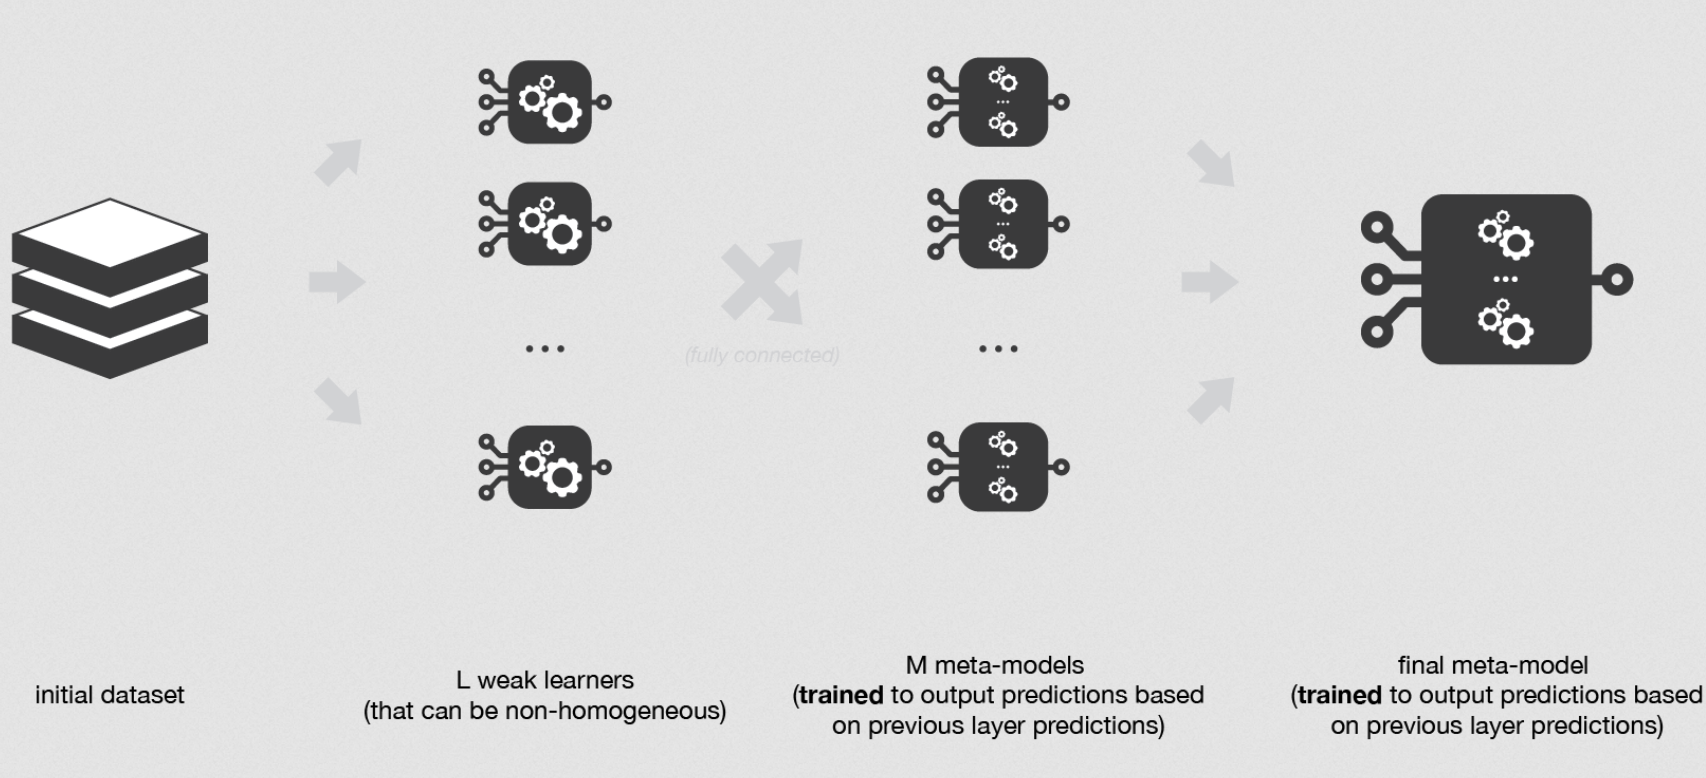

In [24]:
from IPython.display import Image
Image(filename='images/stacking.png')

Dit meta-model, wat alle vorige andere samenvoegt, noemen we ook wel een *blender*. Dit gaan we bekijken in de oefeningen.